Librerías usadas:

In [1]:
import csv
import requests
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

### Clases:

In [2]:
class Coordenada:
    def __init__(self, latitud, longitud):
        self.latitud = latitud
        self.longitud = longitud
    
class Ciudad:
    def __init__(self, nombrePais, nombreCiudad):
        self.nombrePais = nombrePais
        self.nombreCiudad = nombreCiudad
    def getPais(self):
        return self.nombrePais
    
    def getCiudad(self):
        return self.nombreCiudad

### Forma 1:

Obtener a partir de worldcities.csv

In [3]:
class servicioConCSV:
    def __init__(self, csv_path):
        self.csv_path = csv_path
    
    def obtenerCoordenadas(self, ciudad: Ciudad) -> Coordenada:
        df = pd.read_csv(self.csv_path)
        df_ciudad = df[ ( df['city_ascii'] == ciudad.nombreCiudad ) & ( df['country'] == ciudad.nombrePais ) ]
        if not df_ciudad.empty:
            latitud = df_ciudad.iloc[0]['lat']
            longitud = df_ciudad.iloc[0]['lng']
            return Coordenada(latitud, longitud)
        else:
            raise ValueError("No existe la ciudad en el CSV")

In [4]:
# prueba de la funcion
ciudad1 = Ciudad("Japan", "Tokyo")
csv_service = servicioConCSV("worldcities.csv")
coordena1 = csv_service.obtenerCoordenadas(ciudad1)
print(f"La latitud es: { coordena1.latitud } y la longitud es: {coordena1.longitud}")

La latitud es: 35.6897 y la longitud es: 139.6922


### Forma 2:

Usando la api: https://nominatim.openstreetmap.org/search?q=lima,peru&format=json 

In [5]:
class servicioConAPi:
        
    def obtenerCoordenadas(self, ciudad: Ciudad) -> Coordenada:
        nombreCiudad = ciudad.nombreCiudad.lower()
        nombrePais = ciudad.nombrePais.lower()
        headers = {
            "User-Agent": "ActividadSemana09/1.0"
        }
        url = f"https://nominatim.openstreetmap.org/search?q={nombreCiudad},{nombrePais}&format=json"
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            try:
                data = response.json()
                if data:
                    latitud = float(data[0]['lat'])
                    longitud = float(data[0]['lon'])
                    return Coordenada(latitud, longitud)
                else:
                    raise ValueError("Ciudad no encontrada mediante la API")
            except ValueError:
                raise ValueError("Error al procesar la respuesta de la API")
        else:
            raise ValueError("Error en la solicitud a la API")

In [6]:
# prueba de la funcion
ciudad1 = Ciudad("Japan", "Tokyo")

servicio_api = servicioConAPi()

coordena1 = servicio_api.obtenerCoordenadas(ciudad1)
print(f"La latitud es: { coordena1.latitud } y la longitud es: {coordena1.longitud}")

La latitud es: 35.6821936 y la longitud es: 139.762221


### Método Haversine

Según lo requerido se usará Haversine para calcular las distancia entre ambas coordenadas.

La formula se ha obtenido de: https://es.scribd.com/presentation/675358086/Ley-de-Haversine#:~:text=La%20f%C3%B3rmula%20de%20Haversine%20es,el%20radio%20de%20la%20Tierra.

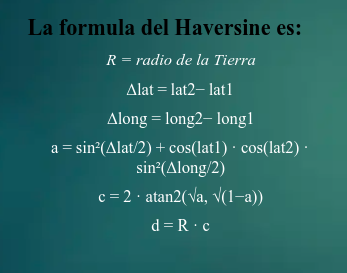

In [7]:
def distHaversine(coord1: Coordenada, coord2: Coordenada) -> float:
    R = 6371 # radio de la tierra en km
    lat1, lon1 = radians(coord1.latitud), radians(coord1.longitud)
    lat2, lon2 = radians(coord2.latitud), radians(coord2.longitud)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))
    return R*c

### Interfaz:

Se va hacer una interfaz para el usuario para que pueda escoger que forma usar. Se va  usar tkinter

In [8]:
def calcular_distancia():
    ciudad1 = Ciudad(imput_pais1.get(), imput_ciudad1.get())
    ciudad2 = Ciudad(imput_pais2.get(), imput_ciudad2.get())
    
    service_choice = service_var.get()
    if service_choice == 1:
        service = servicioConCSV("worldcities.csv")
    elif service_choice == 2:
        service = servicioConAPi()
    # elif service_choice == 3:
    #     service = MockCoordenadasService()
    else:
        result_label.config(text="Por favor, seleccione un servicio válido.")
        return
    
    try:
        coord1 = service.obtenerCoordenadas(ciudad1)
        coord2 = service.obtenerCoordenadas(ciudad2)
        distancia = distHaversine(coord1, coord2)
        result_label.config(text=f"Distancia: {distancia:.2f} km\n{ciudad1.nombreCiudad}: ({coord1.latitud}, {coord1.longitud})\n{ciudad2.nombreCiudad}: ({coord2.latitud}, {coord2.longitud})")
    except ValueError as e:
        result_label.config(text=str(e))

In [9]:
import tkinter as tk
from tkinter import ttk

root = tk.Tk()
root.title("Distancia entre ciudades")

tk.Label(root, text = "Ciudad 1: ").grid(row=0, column=0)
tk.Label(root, text="País 1:").grid(row=1, column=0)
imput_ciudad1 = tk.Entry(root)
imput_pais1 = tk.Entry(root)
imput_ciudad1.grid(row=0, column=1)
imput_pais1.grid(row=1, column=1)

tk.Label(root, text="Ciudad 2:").grid(row=2, column=0)
tk.Label(root, text="País 2:").grid(row=3, column=0)
imput_ciudad2 = tk.Entry(root)
imput_pais2 = tk.Entry(root)
imput_ciudad2.grid(row=2, column=1)
imput_pais2.grid(row=3, column=1)

tk.Label(root, text="Elija el servicio:").grid(row=4, column=0)
service_var = tk.IntVar()
tk.Radiobutton(root, text="CSV", variable=service_var, value=1).grid(row=4, column=1)
tk.Radiobutton(root, text="API", variable=service_var, value=2).grid(row=5, column=1)
# tk.Radiobutton(root, text="Mock", variable=service_var, value=3).grid(row=6, column=1)

ciudad1 = Ciudad(imput_pais1.get(), imput_ciudad1.get())
ciudad2 = Ciudad(imput_pais2.get(), imput_ciudad2.get())

calculate_button = tk.Button(root, text="Calcular Distancia", command=calcular_distancia)
calculate_button.grid(row=7, columnspan=2)

result_label = tk.Label(root, text="", justify="left")
result_label.grid(row=8, columnspan=2)
root.mainloop()